# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
df_std

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# Add means columns
asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])

# Add std columns
asl.df['left-x-std']= asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std']= asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std']= asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std']= asl.df['speaker'].map(df_std['right-y'])

In [12]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean']) / asl.df['right-y-std']
asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean']) / asl.df['right-x-std']
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean']) / asl.df['left-y-std']
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean']) / asl.df['left-x-std']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [13]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

asl.df['polar-rr'] = np.hypot(asl.df['right-x'] - asl.df['nose-x'], asl.df['right-y'] - asl.df['nose-y'])
asl.df['polar-rtheta'] = np.arctan2(asl.df['right-x'] - asl.df['nose-x'], asl.df['right-y'] - asl.df['nose-y'])
asl.df['polar-lr'] = np.hypot(asl.df['left-x'] - asl.df['nose-x'], asl.df['left-y'] - asl.df['nose-y'])
asl.df['polar-ltheta'] = np.arctan2(asl.df['left-x'] - asl.df['nose-x'], asl.df['left-y'] - asl.df['nose-y'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [14]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

Generate new means and std values for the polar coordinates

In [15]:
features_polar

['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [16]:
import copy
columns_polar = copy.deepcopy(features_polar)
columns_polar.append('speaker')
columns_polar

['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta', 'speaker']

In [17]:
df_means_polar = asl.df[columns_polar].groupby('speaker').mean()
df_std_polar = asl.df[columns_polar].groupby('speaker').std()

In [18]:
df_means_polar

,polar-rr,polar-rtheta,polar-lr,polar-ltheta
speaker,,,,
man-1,95.464412,-0.307396,161.326053,0.209727
woman-1,65.125528,-0.302214,105.968447,0.060601
woman-2,67.297449,-0.258632,120.640838,0.132688


In [19]:
df_std_polar

,polar-rr,polar-rtheta,polar-lr,polar-ltheta
speaker,,,,
man-1,49.130795,0.383495,34.261750,0.162199
woman-1,30.654063,0.397837,25.133829,0.219121
woman-2,35.581422,0.472623,27.234249,0.181267


In [20]:
# Add polar means columns
asl.df['polar-rr-mean']= asl.df['speaker'].map(df_means_polar['polar-rr'])
asl.df['polar-rtheta-mean']= asl.df['speaker'].map(df_means_polar['polar-rtheta'])
asl.df['polar-lr-mean']= asl.df['speaker'].map(df_means_polar['polar-lr'])
asl.df['polar-ltheta-mean']= asl.df['speaker'].map(df_means_polar['polar-ltheta'])

# Add polar std columns
asl.df['polar-rr-std']= asl.df['speaker'].map(df_std_polar['polar-rr'])
asl.df['polar-rtheta-std']= asl.df['speaker'].map(df_std_polar['polar-rtheta'])
asl.df['polar-lr-std']= asl.df['speaker'].map(df_std_polar['polar-lr'])
asl.df['polar-ltheta-std']= asl.df['speaker'].map(df_std_polar['polar-ltheta'])

In [21]:
asl.df['norm-polar-rr'] = (asl.df['polar-rr'] - asl.df['polar-rr-mean']) / asl.df['polar-rr-std']
asl.df['norm-polar-rtheta'] = (asl.df['polar-rtheta'] - asl.df['polar-rtheta-mean']) / asl.df['polar-rtheta-std']
asl.df['norm-polar-lr'] = (asl.df['polar-lr'] - asl.df['polar-lr-mean']) / asl.df['polar-lr-std']
asl.df['norm-polar-ltheta'] = (asl.df['polar-ltheta'] - asl.df['polar-ltheta-mean']) / asl.df['polar-ltheta-std']

features_norm_polar = ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr','norm-polar-ltheta']

In [22]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# TODO define a list named 'features_custom' for building the training set

asl.df['delta-prr'] = asl.df['polar-rr'].diff().fillna(0)
asl.df['delta-prt'] = asl.df['polar-rtheta'].diff().fillna(0)
asl.df['delta-plr'] = asl.df['polar-lr'].diff().fillna(0)
asl.df['delta-plt'] = asl.df['polar-ltheta'].diff().fillna(0)

features_custom = ['delta-prr', 'delta-prt', 'delta-plr', 'delta-plt']
features_delta_polar = ['delta-prr', 'delta-prt', 'delta-plr', 'delta-plt']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [23]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.021s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [24]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433187


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [25]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [26]:
my_testword = 'FISH'
model, logL = train_a_word(my_testword, 4, features_delta) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for FISH is 4
hidden state #0
mean =  [ 0.  0.  0.  0.]
variance =  [ 0.000625  0.000625  0.000625  0.000625]

hidden state #1
mean =  [ 0.          0.          1.39998332 -4.60001991]
variance =  [  1.99998988e-03   1.99998988e-03   2.24204464e+00   2.64208508e+00]

hidden state #2
mean =  [ 0.  0. -2. -9.]
variance =  [ 0.01000024  0.01000024  0.01000024  0.01000024]

hidden state #3
mean =  [ 1.5  2.5 -1.   1.5]
variance =  [ 0.255  2.255  1.005  2.255]

logL = 163.83318005968547


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [27]:
%matplotlib inline

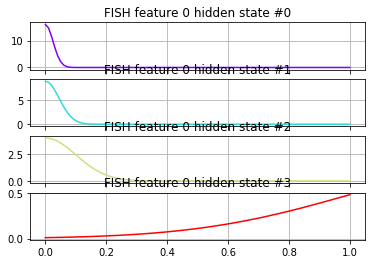

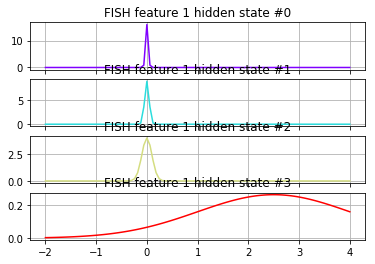

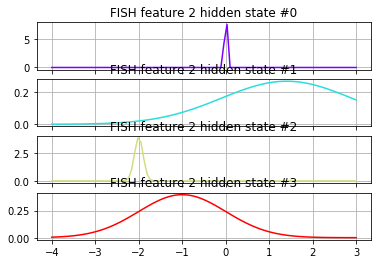

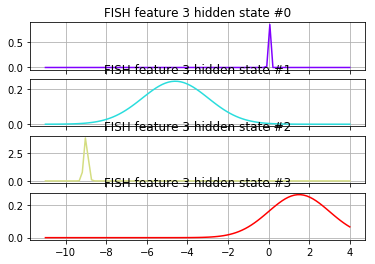

In [28]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [29]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [30]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


In [31]:
from sklearn.model_selection import KFold
from asl_utils import combine_sequences

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
#print(word_sequences)
X, lengths = training.get_word_Xlengths(word)
#print(X)
#print(lengths)
min_n_components = 2
max_n_components = 5

split_method = KFold(n_splits=min(3, len(lengths)))
for n_components in range(min_n_components, max_n_components + 1):
    scores = []
    for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
        print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds
        train_X, train_lengths = combine_sequences(cv_train_idx, word_sequences)
        test_X, test_lengths = combine_sequences(cv_test_idx, word_sequences)
        try:
            model = GaussianHMM(n_components=n_components, n_iter=1000).fit(train_X, train_lengths)
            score = model.score(test_X, test_lengths)
            scores.append(score)
        except:
            break
        print(model.n_components)
        print(score)
    if (len(scores) > 0):
        avg_score = sum(scores) / len(scores)
    else:
        avg_score = 0
    print("Scores" + str(scores))
    print("Avg score" + str(avg_score))


Train fold indices:[2 3 4 5] Test fold indices:[0 1]
2
-1413.03949109
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
2
-437.283598402
Train fold indices:[0 1 2 3] Test fold indices:[4 5]
2
-348.9858525
Scores[-1413.039491092959, -437.28359840234924, -348.98585249960507]
Avg score-733.102980665
Train fold indices:[2 3 4 5] Test fold indices:[0 1]
3
-4152.54838925
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
3
-540.873963602
Train fold indices:[0 1 2 3] Test fold indices:[4 5]
3
-2102.6525111
Scores[-4152.5483892523571, -540.87396360189223, -2102.6525110979255]
Avg score-2265.35828798
Train fold indices:[2 3 4 5] Test fold indices:[0 1]
4
-2361.76678654
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
4
-540.873963602
Train fold indices:[0 1 2 3] Test fold indices:[4 5]
4
-2273.36037672
Scores[-2361.7667865443314, -540.87396360189223, -2273.3603767175478]
Avg score-1725.33370895
Train fold indices:[2 3 4 5] Test fold indices:[0 1]
5
-4767.69532593
Train fold indices:[0 

**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [83]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [26]:
# TODO: Implement SelectorCV in my_model_selector.py
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorCV

features_list = [features_ground, features_norm, features_polar, features_delta]
#features_list = [features_ground]
for features in features_list:
    print("Training started with {} features".format(features))
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorCV(sequences, Xlengths, word, min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))

Training started with ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly'] features
Training complete for FISH with 3 states with time 0.017947377964501254 seconds
Training complete for BOOK with 6 states with time 4.76890489647339 seconds
Training complete for VEGETABLE with 2 states with time 1.885490365798585 seconds
Training complete for FUTURE with 2 states with time 4.695603198171692 seconds
Training complete for JOHN with 12 states with time 52.46949155296758 seconds
Training started with ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly'] features
Training complete for FISH with 3 states with time 0.01606954689145823 seconds
Training complete for BOOK with 5 states with time 4.979904085640385 seconds
Training complete for VEGETABLE with 15 states with time 2.493012552515978 seconds
Training complete for FUTURE with 2 states with time 5.208260489510494 seconds
Training complete for JOHN with 8 states with time 68.1710947442968 seconds
Training started with ['polar-rr', 'polar-rtheta', 'polar-l

In [32]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorBIC

#features_list = [features_ground, features_norm, features_polar, features_delta]
features_list = [features_polar]
for features in features_list:
    print("Training started with {} features".format(features))
    training = asl.build_training(features_delta)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorBIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))

Training started with ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta'] features


NameError: name 'words_to_train' is not defined

In [28]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorDIC


#features_list = [features_ground, features_norm, features_polar, features_delta]
features_list = [features_polar]
for features in features_list:
    print("Training started with {} features".format(features))
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorDIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))

Training started with ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly'] features
Training complete for FISH with 3 states with time 1.2473549566871043 seconds
Training complete for BOOK with 15 states with time 5.81958837395473 seconds
Training complete for VEGETABLE with 15 states with time 4.840822277038114 seconds
Training complete for FUTURE with 15 states with time 6.177140496489756 seconds
Training complete for JOHN with 15 states with time 29.711643664554686 seconds
Training started with ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly'] features
Training complete for FISH with 2 states with time 4.142122860016684 seconds
Training complete for BOOK with 15 states with time 5.754769203399292 seconds
Training complete for VEGETABLE with 5 states with time 4.798360458035177 seconds
Training complete for FUTURE with 14 states with time 5.472663039015856 seconds
Training complete for JOHN with 14 states with time 30.635130280678254 seconds
Training started with ['polar-rr', 'polar-rtheta', 'pol

**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [29]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 85.010s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [33]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    
    for word in training.words:
    #for word in words_to_train:
        #print(word)
        model = model_selector(sequences, Xlengths, word, n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_norm_polar, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


In [78]:
import re
import arpa
import math
import operator

In [62]:
def get_n_gram_score(sentence, n_gram_model, n_gram):
    if len(sentence) > 0 and len(sentence) > n_gram:
        n_gram_len = n_gram
    else:
        n_gram_len = len(sentence)
    n_gram_sentence = " ".join(sentence[-n_gram_len:])
    try:
        n_gram_score = n_gram_model.log_s(n_gram_sentence)
    except:
        n_gram_score = n_gram_model.log_s("[UNKNOWN]")
    return n_gram_score

def get_n_gram_p(sentence, n_gram_model, n_gram):
    if len(sentence) > 0 and len(sentence) > n_gram:
        n_gram_len = n_gram
    else:
        n_gram_len = len(sentence)
    n_gram_sentence = " ".join(sentence[-n_gram_len:])
    try:
        n_gram_p = n_gram_model.s(n_gram_sentence)
    except:
        n_gram_p = n_gram_model.s("[UNKNOWN]")
    return n_gram_p

lm_models = arpa.loadf("ukn.3.lm")
lm = lm_models[0]

In [63]:
get_n_gram_score(["<s>", "JHON"], lm, 3)

-4.612356800000001

In [129]:
sentence_start = []
sentence_end = []
sentences = test_set._load_sentence_word_indices()
for k, v in sentences.items():
    sentence_start.append(v[0])
    sentence_end.append(v[-1:])

In [130]:
sentence_string = ["<s>"]
sentence = copy.deepcopy(sentences[2])
test_word_index = sentence[0]

In [131]:
sentence

[0, 1, 2]

In [42]:
word_probabilities = {}
word_scores = {}
word_ngram_scores = {}
word_n_gram_p = {}
best_score = float("-inf")
best_p = 0
guess = None

In [47]:
if test_word_index in sentence_start:
    test_sentence = ["<s>"]
test_sentence

['<s>']

In [72]:
test_word_index = 0
test_word_index

0

In [73]:
test_X, test_lenghts = test_set.get_item_Xlengths(test_word_index)

In [82]:
for word, model in models.items():
    # logger.debug("Model {}".format(model))

    cleaned_word = re.sub(r'\d+$', '', word)
    ngram_sentence = copy.deepcopy(test_sentence)
    ngram_sentence.append(cleaned_word)

    n_gram_score = get_n_gram_score(test_sentence, n_gram_model = lm, n_gram = 3)
    n_gram_p = get_n_gram_p(test_sentence, n_gram_model = lm, n_gram = 3)

    try:
        score = model.score(test_X, test_lenghts)
    except:
        score = float("-inf")

    word_probabilities.update({word: math.exp(score)})
    word_scores.update({word: score})
    word_ngram_scores.update({word: n_gram_score})
    word_n_gram_p.update({word: n_gram_p})

In [89]:
word_scores1 = word_scores

In [90]:
word_ngram_scores1 = word_ngram_scores

In [92]:
sorted(word_scores1.items(), key=operator.itemgetter(1), reverse = True)

[('WOMAN', -33.250086605528331),
 ('MARY', -39.208625105209421),
 ('JOHN', -45.568281242664327),
 ('FUTURE', -45.914824270834778),
 ('VISIT', -47.237340272282417),
 ('POSS', -56.682439079187084),
 ('IX', -57.997242117275391),
 ('GO', -64.592426042166494),
 ('YESTERDAY', -77.704561975343978),
 ('SOMETHING-ONE', -78.683581097824899),
 ('MOTHER', -79.191591873144489),
 ('GIVE1', -81.92026194443342),
 ('SHOULD', -82.221348443569653),
 ('WHO', -97.148323055086408),
 ('SEE', -107.58617762222387),
 ('GIVE', -120.41375026719037),
 ('NOT', -124.73526338980258),
 ('WRITE', -128.77854493573537),
 ('HAVE', -136.59112921702757),
 ('WHAT', -142.17766385153402),
 ('ARRIVE', -146.08894654597296),
 ('LOVE', -146.91491309367379),
 ('IX-1P', -150.10586590038599),
 ('BLAME', -189.15120408967391),
 ('FINISH', -190.494451419895),
 ('NEW', -198.5545270697468),
 ('BOX', -206.53951404502513),
 ('BROTHER', -230.5019260624903),
 ('LIKE', -261.13617954559413),
 ('BUY', -265.75463599887337),
 ('TELL', -266.0762465

In [91]:
sorted(word_ngram_scores1.items(), key=operator.itemgetter(1), reverse = True)

[('JOHN', -101.79787379999999),
 ('WRITE', -101.79787379999999),
 ('HOMEWORK', -101.79787379999999),
 ('IX-1P', -101.79787379999999),
 ('SEE', -101.79787379999999),
 ('YESTERDAY', -101.79787379999999),
 ('IX', -101.79787379999999),
 ('LOVE', -101.79787379999999),
 ('MARY', -101.79787379999999),
 ('CAN', -101.79787379999999),
 ('GO', -101.79787379999999),
 ('GO1', -101.79787379999999),
 ('FUTURE', -101.79787379999999),
 ('GO2', -101.79787379999999),
 ('PARTY', -101.79787379999999),
 ('FUTURE1', -101.79787379999999),
 ('HIT', -101.79787379999999),
 ('BLAME', -101.79787379999999),
 ('FRED', -101.79787379999999),
 ('FISH', -101.79787379999999),
 ('WONT', -101.79787379999999),
 ('EAT', -101.79787379999999),
 ('BUT', -101.79787379999999),
 ('CHICKEN', -101.79787379999999),
 ('VEGETABLE', -101.79787379999999),
 ('CHINA', -101.79787379999999),
 ('PEOPLE', -101.79787379999999),
 ('PREFER', -101.79787379999999),
 ('BROCCOLI', -101.79787379999999),
 ('LIKE', -101.79787379999999),
 ('LEAVE', -101.

In [85]:
test_set.wordlist

['JOHN',
 'WRITE',
 'HOMEWORK',
 'JOHN',
 'CAN',
 'GO',
 'CAN',
 'JOHN',
 'CAN',
 'GO',
 'CAN',
 'JOHN',
 'FISH',
 'WONT',
 'EAT',
 'BUT',
 'CAN',
 'EAT',
 'CHICKEN',
 'JOHN',
 'LIKE',
 'IX',
 'IX',
 'IX',
 'JOHN',
 'LIKE',
 'IX',
 'IX',
 'IX',
 'JOHN',
 'LIKE',
 'IX',
 'IX',
 'IX',
 'MARY',
 'VEGETABLE',
 'KNOW',
 'IX',
 'LIKE',
 'CORN1',
 'JOHN',
 'IX',
 'THINK',
 'MARY',
 'LOVE',
 'JOHN',
 'MUST',
 'BUY',
 'HOUSE',
 'FUTURE',
 'JOHN',
 'BUY',
 'CAR',
 'SHOULD',
 'JOHN',
 'SHOULD',
 'NOT',
 'BUY',
 'HOUSE',
 'JOHN',
 'DECIDE',
 'VISIT',
 'MARY',
 'JOHN',
 'FUTURE',
 'NOT',
 'BUY',
 'HOUSE',
 'JOHN',
 'WILL',
 'VISIT',
 'MARY',
 'JOHN',
 'NOT',
 'VISIT',
 'MARY',
 'ANN',
 'BLAME',
 'MARY',
 'IX-1P',
 'FIND',
 'SOMETHING-ONE',
 'BOOK',
 'JOHN',
 'IX',
 'GIVE',
 'MAN',
 'IX',
 'NEW',
 'COAT',
 'JOHN',
 'GIVE',
 'IX',
 'SOMETHING-ONE',
 'WOMAN',
 'BOOK',
 'JOHN',
 'GIVE',
 'IX',
 'SOMETHING-ONE',
 'WOMAN',
 'BOOK',
 'POSS',
 'NEW',
 'CAR',
 'BREAK-DOWN',
 'JOHN',
 'LEG',
 'JOHN',
 'POSS'

['Word', 'scores_0', 'scores_1', 'scores_2']

In [190]:
columns_list = ['Word']
for i in sentence:
    columns_list.append("scores_{}".format(i))
best_scores_df = pd.DataFrame(columns=columns_list)
best_scores_df


,Word,scores_0,scores_1,scores_2


In [191]:
 scores_df.loc[0] = ['JOHN', 1, 2, 3]

In [192]:
scores_df

,Word,scores_0,scores_1,scores_2
0,JOHN,1.0,2.0,3.0


In [119]:
sentence_ngram = ["<s>"]
sentence_ngram
sentences_end

NameError: name 'sentences_end' is not defined

In [207]:
viterbi_sentence = ['JOHN']
viterbi_sentence

['JOHN']

In [208]:
n = len(viterbi_sentence)
n

1

In [209]:
words = viterbi_sentence
words

['JOHN']

In [164]:
best = [1.0] + [0.0] * n
best

[1.0, 0.0, 0.0, 0.0, 0.0]

In [165]:
get_n_gram_score(["<s>", "JHON"], lm, 3)

{'ALL': GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
       covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
       min_covar=0.001, n_components=3, n_iter=1000, params='stmc',
       random_state=14, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
       verbose=False),
 'ANN': GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
       covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
       min_covar=0.001, n_components=3, n_iter=1000, params='stmc',
       random_state=14, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
       verbose=False),
 'APPLE': GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
       covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
       min_covar=0.001, n_components=3, n_iter=1000, params='stmc',
       random_state=14, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
       verbose=False),
 'ARRIVE': GaussianHMM(

In [176]:
words = ["<s>"] + (viterbi_sentence)
words

['<s>', 'JOHN', 'WRITE', 'HOMEWORK']

In [ ]:
def viterbi_segment(text, P):
    """Find the best segmentation of the string of characters, given the
    UnigramTextModel P."""
    # best[i] = best probability for text[0:i]
    # words[i] = best word ending at position i
    n = len(text)
    words = [''] + list(text)
    best = [1.0] + [0.0] * n
    # Fill in the vectors best, words via dynamic programming
    for i in range(n+1):
        for j in range(0, i):
            w = text[j:i]
            if P[w] * best[i - len(w)] >= best[i]:
                best[i] = P[w] * best[i - len(w)]
                words[i] = w
    # Now recover the sequence of best words
    sequence = []
    i = len(words)-1
    while i > 0:
        sequence[0:0] = [words[i]]
        i = i - len(words[i])
    # Return sequence of best words and overall probability
return sequence, best[-1]

In [177]:
test_set

In [181]:
sentence_indexes = [0, 1]
sentence_length = len(sentence_indexes)
best = [1.0] + [0.0] * sentence_length
best

[1.0, 0.0, 0.0]

In [ ]:
best_df = pd.DataFrame(Columns = 'Word')

In [182]:
test_word_index = 0
test_X, test_lenghts = test_set.get_item_Xlengths(test_word_index)

In [183]:
list_sentence = ["<s>"]
list_sentence

['<s>']

In [185]:
lm

In [194]:
column_list = ["scores_{}".format(i) for i in sentence_indexes]

['scores_0', 'scores_1']

In [201]:
best_scores_df = pd.DataFrame(0, index=np.arange(len(models)), columns=["scores_{}".format(i) for i in sentence_indexes])
best_scores_df.insert(0, "Word", list(models.keys()))
best_scores_df

,Word,scores_0,scores_1
0,JOHN,0,0
1,WRITE,0,0
2,HOMEWORK,0,0
3,IX-1P,0,0
4,SEE,0,0
5,YESTERDAY,0,0
6,IX,0,0
7,LOVE,0,0
8,MARY,0,0
9,CAN,0,0


In [205]:
best_scores_df.set_value('JHONny', 'scores_0', 10)
best_scores_df.head()

,Word,scores_0,scores_1
0,JOHN,0.0,0.0
1,WRITE,0.0,0.0
2,HOMEWORK,0.0,0.0
3,IX-1P,0.0,0.0
4,SEE,0.0,0.0


In [293]:
test_set.get_item_Xlengths(test_word_index)

(array([[-0.80949269,  0.44706451, -1.53592863,  0.19851537],
        [-0.55833098,  0.81200156, -1.91367186,  0.51601734],
        [-0.25479849,  0.49602445, -2.1229022 ,  0.42007995],
        [-0.38451631,  0.47629104, -2.11648402,  0.50555703],
        [-0.39064314,  0.23564548, -2.01525919,  0.72137331],
        [-0.53372329,  0.08135114, -1.96758568,  0.78268605],
        [-0.597204  , -0.11702641, -1.96758568,  0.78268605],
        [-0.69027172,  0.00513388, -1.82828419,  0.56463534],
        [-0.62072706,  0.20999745, -1.82828419,  0.56463534],
        [-0.64354571,  0.42646173, -1.97075592,  0.29095326],
        [-0.49930914,  0.30305102, -2.01023018,  0.30116285],
        [-0.69138513,  0.24102791, -2.01023018,  0.30116285],
        [-0.75518031,  0.21649251, -2.01023018,  0.30116285],
        [-0.92814082,  0.27691168, -2.01023018,  0.30116285]]), [14])

In [527]:
#sentence_index = [0, 1, 2]
sentence_index = [3, 4, 5, 6]
#sentence_index = [7, 8, 9, 10]
besty = 0

In [528]:
besty = get_sentence_score(sentence_index, models, test_set)

scores_0
Index([], dtype='object')
Diff -123.53991406101827
Diff 136.4208297071012
Diff 276.7006620711151
Diff 28.770575576791487
Diff -25.064239192405125
Diff 114.58331153869139
Diff -70.83693184777172
Diff 30.468934396888045
Diff -81.08265949839034
Diff 296.1050189431315
Diff -39.28874284570729
Diff 590.2043364755527
Diff -76.83382192437631
Diff 2482.318913677448
Diff 7767.877575068679
Diff 1284.223763417139
Diff 334.93473774900565
Diff 33.2939559204888
Diff 1255.96344164917
Diff 1376.8996768658958
Diff 13.354673180110197
Diff 451.2369111239381
Diff 963.5945705229416
Diff 1521.3723555620954
Diff 232.79909376936573
Diff 420.18158809890167
Diff 655.3450488442701
Diff 246.50566107570916
Diff 270.1816436289665
Diff -31.193668261997615
Diff -31.104878644491606
Diff 528.1646849396195
Diff 85.47994823317711
Diff 383.4085769832983
Diff 585.9500777405653
Diff 417.54754312242164
Diff 657.7132296789515
Diff 1031.1699984949241
Diff 18.018181933937697
Diff 288.24441413551114
Diff 1706.28935064315

Diff 921.5405310898814
Diff -764.7364182748843
Diff 4455.098422656127
Diff 502.0128139760882
Diff -1729.06524414238
Diff 5440.307947683333
Diff -1905.789516517112
Diff -2935.031573065779
Diff -17.020297964326346
Diff -2118.5797569493348
Diff -2824.4944860525643
Diff -972.5860993688584
Diff -3061.0640668079727
Diff 2401.697903239032
Diff -2691.4921428441608
Diff -2313.303778277013
Diff -989.779756435646


In [268]:
besty.get_value('JOHN', 'scores_0')

147.4433005426643

In [265]:
top_best = 3
test_word_index = 1
best_previous_words = besty.sort_values("scores_{}".format(test_word_index - 1))[0:top_best].index
best_previous_words

Index(['WOMAN', 'MARY', 'JOHN'], dtype='object')

In [257]:
ngram_sentence = ['<s>', 'WOMAN', 'WORK']
get_n_gram_score(ngram_sentence, n_gram_model = lm, n_gram = 3)

-4.612356800000001

In [258]:
ngram_sentence = ['<s>', 'MARY', 'WORK']
get_n_gram_score(ngram_sentence, n_gram_model = lm, n_gram = 3)

-4.612356800000001

In [259]:
ngram_sentence = ['<s>', 'JOHN', 'WORK']
get_n_gram_score(ngram_sentence, n_gram_model = lm, n_gram = 3)

-4.612356800000001

In [260]:
ngram_sentence = ['<s>', 'WOMAN', 'WRITE']
get_n_gram_score(ngram_sentence, n_gram_model = lm, n_gram = 3)

-106.2596249

In [261]:
ngram_sentence = ['<s>', 'MARY', 'WRITE']
get_n_gram_score(ngram_sentence, n_gram_model = lm, n_gram = 3)

-105.84589929999999

In [262]:
ngram_sentence = ['<s>', 'JOHN', 'WRITE']
get_n_gram_score(ngram_sentence, n_gram_model = lm, n_gram = 3)

-103.86458799999997

In [149]:
def ngram_search(sentence_indexes, models):
    for i in sentence_indexes:
        initial_sentence = 
        sentence_score = get_sentence_score(initial_sentence, models)
    print(sentence_score)

In [147]:
get_sentence_score(sentence_ngram, models)

{'<s> ALL': -103.64310470000001,
 '<s> ANN': -103.64719969999999,
 '<s> APPLE': -103.7170678,
 '<s> ARRIVE': -102.83331189999998,
 '<s> BILL': -104.1858057,
 '<s> BLAME': -103.2127394,
 '<s> BLUE': -104.01928679999997,
 '<s> BOOK': -102.62817919999998,
 '<s> BORROW': -104.48802469999998,
 '<s> BOX': -103.26226,
 '<s> BOY': -104.1858057,
 '<s> BREAK-DOWN': -103.79913429999999,
 '<s> BROCCOLI': -103.79913429999999,
 '<s> BROTHER': -104.4868357,
 '<s> BUT': -104.48802469999998,
 '<s> BUY': -103.68729300000001,
 '<s> CAN': -103.3448621,
 '<s> CANDY': -103.79913429999999,
 '<s> CAR': -103.71290300000001,
 '<s> CHICAGO': -103.79913429999999,
 '<s> CHICKEN': -103.79913429999999,
 '<s> CHINA': -104.48802469999998,
 '<s> CHOCOLATE': -104.01928679999997,
 '<s> COAT': -103.79913429999999,
 '<s> CORN': -103.26226,
 '<s> DECIDE': -104.48802469999998,
 '<s> EAT': -104.1858057,
 '<s> FIND': -104.48802469999998,
 '<s> FINISH': -104.2311665,
 '<s> FISH': -104.48802469999998,
 '<s> FRANK': -103.2488037,

In [150]:
ngram_search(sentence, models)

{'<s> JOHN': -101.87501929999999, '<s> WRITE': -104.48802469999998, '<s> HOMEWORK': -103.79913429999999, '<s> IX-1P': -103.1363187, '<s> SEE': -104.0093177, '<s> YESTERDAY': -103.1685731, '<s> IX': -101.9304869, '<s> LOVE': -102.84994799999998, '<s> MARY': -102.16857490000001, '<s> CAN': -103.3448621, '<s> GO': -103.84514469999999, '<s> FUTURE': -102.87562989999998, '<s> PARTY': -104.48802469999998, '<s> HIT': -104.48802469999998, '<s> BLAME': -103.2127394, '<s> FRED': -104.48802469999998, '<s> FISH': -104.48802469999998, '<s> WONT': -104.4868357, '<s> EAT': -104.1858057, '<s> BUT': -104.48802469999998, '<s> CHICKEN': -103.79913429999999, '<s> VEGETABLE': -103.6096047, '<s> CHINA': -104.48802469999998, '<s> PEOPLE': -103.5365687, '<s> PREFER': -103.8841817, '<s> BROCCOLI': -103.79913429999999, '<s> LIKE': -103.3867191, '<s> LEAVE': -104.48802469999998, '<s> SAY': -104.1858057, '<s> BUY': -103.68729300000001, '<s> HOUSE': -103.7170678, '<s> KNOW': -104.4868357, '<s> CORN': -103.26226, '

('all', 'this', 'happened')
('this', 'happened', 'more')
('happened', 'more', 'or')
('more', 'or', 'less')


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [85]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [ ]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors
from utils import config_log

config_log()

In [105]:
# TODO Choose a feature set and model selector
model_selector = SelectorConstant # change as needed

#features_list = [features_ground, features_norm, features_polar, features_norm_polar, features_delta_polar, features_delta]
features_list = [features_norm_polar]
for features in features_list:
    print("Training started with {} features".format(features))
    # TODO Recognize the test set and display the result with the show_errors method
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    show_errors(guesses, test_set)

Training started with ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta'] features
Diff average -1057.3601940392107
Diff average -2867.456156175786
Diff average -3852.9656823371574
Diff average -1046.5737799214737
Diff average -1128.3849914121688
Diff average -792.7253106953356
Diff average -1932.107930661603
Diff average -486.68035185434877
Diff average -1725.21038294153
Diff average -1602.9811840510533
Diff average -4466.954656063271
Diff average -1702.3432343196275
Diff average -2943.3896267980062
Diff average -802.6198464071737
Diff average -684.8602798114613
Diff average -3571.6241011288803
Diff average -3361.695966817779
Diff average -962.927169646108
Diff average -1038.1370453919262
Diff average -1115.126216833168
Diff average -508.27890812820925
Diff average -1531.2813155503368
Diff average -565.5170538652511
Diff average -1312.0305700308365
Diff average -827.0864497577534
Diff average -590.4865391136938
Diff average -1126.4243251926407
Diff average -72

In [34]:
# TODO Choose a feature set and model selector
model_selector = SelectorCV # change as needed

features_list = [features_ground, features_norm, features_polar, features_norm_polar, features_delta_polar, features_delta]
for features in features_list:
    print("Training started with {} features".format(features))
    # TODO Recognize the test set and display the result with the show_errors method
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    show_errors(guesses, test_set)

Training started with ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly'] features

**** WER = 0.5786516853932584
Total correct: 75 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *NEW                                               JOHN WRITE HOMEWORK
    7: JOHN *WHAT GO *HAVE                                           JOHN CAN GO CAN
   12: JOHN *TEACHER *CAN CAN                                        JOHN CAN GO CAN
   21: JOHN *HOMEWORK *NEW *PREFER *CAR *CAR *VISIT *EAT             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *IX IX IX *LOVE                                        JOHN LIKE IX IX IX
   28: JOHN *TELL IX IX *LOVE                                        JOHN LIKE IX IX IX
   30: JOHN LIKE IX IX *GO                                           JOHN LIKE IX IX IX
   36: MARY VEGETABLE *GIVE *GO *MARY *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *APPLE *JOHN *GO                   

   77: *JOHN BLAME *SOMETHING-ONE                                    ANN BLAME MARY
   84: *HOMEWORK *ARRIVE *POSS *COAT                                 IX-1P FIND SOMETHING-ONE BOOK
   89: *MAN *GIVE *IX *SOMETHING-ONE IX *ARRIVE *BOOK                JOHN IX GIVE MAN IX NEW COAT
   90: JOHN *GIVE1 *WOMAN *GIVE3 WOMAN *CHOCOLATE                    JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *WOMAN IX *IX *SOMETHING-ONE BOOK                        JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
  105: JOHN *FRANK                                                   JOHN LEG
  107: JOHN *GIVE *HAVE *GO *WHO                                     JOHN POSS FRIEND HAVE CANDY
  108: *MARY *HOMEWORK                                               WOMAN ARRIVE
  113: *GO *HAVE BLUE *JANA *BUY1                                    IX CAR BLUE SUE BUY
  119: *VEGETABLE *BUY1 *GO *HAVE *GIVE                           

In [93]:
# TODO Choose a feature set and model selector
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorBIC

model_selector = SelectorBIC # change as needed

features_list = [features_ground, features_norm, features_polar, features_norm_polar, features_delta_polar, features_delta]
for features in features_list:
    print("Training started with {} features".format(features))
    # TODO Recognize the test set and display the result with the show_errors method
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    show_errors(guesses, test_set)

Training started with ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly'] features
Alpha 0

**** WER = 0.6067415730337079
Total correct: 70 out of 178
Training started with ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly'] features
Alpha 0

**** WER = 0.6067415730337079
Total correct: 70 out of 178
Training started with ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta'] features
Alpha 0

**** WER = 0.5674157303370787
Total correct: 77 out of 178
Training started with ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta'] features
Alpha 0

**** WER = 0.5617977528089888
Total correct: 78 out of 178
Training started with ['delta-prr', 'delta-prt', 'delta-plr', 'delta-plt'] features
Alpha 0

**** WER = 0.6067415730337079
Total correct: 70 out of 178
Training started with ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly'] features
Alpha 0

**** WER = 0.651685393258427
Total correct: 62 out of 178


In [36]:
# TODO Choose a feature set and model selector
model_selector = SelectorDIC # change as needed

features_list = [features_ground, features_norm, features_polar, features_norm_polar, features_delta_polar, features_delta]
for features in features_list:
    print("Training started with {} features".format(features))
    # TODO Recognize the test set and display the result with the show_errors method
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    show_errors(guesses, test_set)

Training started with ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly'] features

**** WER = 0.5955056179775281
Total correct: 72 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *BOX *ARRIVE *ARRIVE                           JOHN CAN GO CAN
   12: *IX *WHAT *CAN CAN                                            JOHN CAN GO CAN
   21: JOHN *GIVE1 *JOHN *FUTURE *GIVE1 *CAR *FUTURE *MARY           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *WHO IX IX *LOVE                                         JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *VISIT *VISIT *IX *GO *MARY *IX                               MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *GO *GIVE MARY *MARY                    

   90: JOHN GIVE IX SOMETHING-ONE *GO *ARRIVE                        JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
   92: JOHN *WOMAN IX *WOMAN WOMAN BOOK                              JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
  105: JOHN *SEE                                                     JOHN LEG
  107: JOHN POSS *HAVE HAVE *GO                                      JOHN POSS FRIEND HAVE CANDY
  108: *MARY *BOOK                                                   WOMAN ARRIVE
  113: IX CAR *IX *IX *BOX                                           IX CAR BLUE SUE BUY
  119: *MARY *BUY1 IX *BLAME *GO                                     SUE BUY IX CAR BLUE
  122: JOHN *GIVE1 BOOK                                              JOHN READ BOOK
  139: JOHN *BUY1 WHAT *MARY *ARRIVE                                 JOHN BUY WHAT YESTERDAY BOOK
  142: JOHN BUY YESTERDAY WHAT BOOK                                  JOHN BU

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [ ]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [52]:
data = np.array([['','Col1','Col2'],
                ['Row1',1,2],
                ['Row2',3,4]])
data_df = pd.DataFrame(data=data[1:,1:],
                  index=data[1:,0],
                  columns=data[0,1:])
data_df

,Col1,Col2
Row1,1,2
Row2,3,4


In [58]:
test_set

In [78]:
from my_recognizer import get_emission_scores

sentence_index = [0, 1, 2]
emission_scores = get_emission_scores(sentence_index, models, test_set)

Score column scores_0
Clean word JOHN
Emission score -60.99650766613433
Score -60.99650766613433
Clean word WRITE
Emission score -712.157000172256
Score -712.157000172256
Clean word HOMEWORK
Emission score -1191.8553330413513
Score -1191.8553330413513
Clean word IX-1P
Emission score -610.586739418271
Score -610.586739418271
Clean word SEE
Emission score -381.2814867892379
Score -381.2814867892379
Clean word YESTERDAY
Emission score -246.1758471495479
Score -246.1758471495479
Clean word IX
Emission score -81.95643193365791
Score -81.95643193365791
Clean word LOVE
Emission score -216.5151933133968
Score -216.5151933133968
Clean word MARY
Emission score -84.28324705652311
Score -84.28324705652311
Clean word CAN
Emission score -344.6163301646409
Score -344.6163301646409
Clean word GO
Emission score -60.691360531207096
Score -60.691360531207096
Clean word GO
Emission score -2092.3321029848366
Score -2153.0234635160436
Clean word FUTURE
Emission score -70.8790113013888
Score -70.879011301388

In [79]:
emission_scores

,scores_0,scores_1,scores_2
JOHN,-60.996508,-214,-499
WRITE,-712.157000,5,-1668
HOMEWORK,-1191.855333,-367,-397
IX-1P,-610.586739,-11446,-11338
SEE,-381.281487,-9604,-8673
YESTERDAY,-246.175847,-442,-678
IX,-81.956432,-729,-800
LOVE,-216.515193,-202,-407
MARY,-84.283247,-248,-583
CAN,-344.616330,-202,-385


In [83]:
list(emission_scores.idxmax(axis = 0))

['JOHN', 'WRITE', 'ARRIVE']

In [86]:
[v for k, v in emission_scores.to_dict().items()]

[{'ALL': -1404.6765292866926,
  'ANN': -442.26759198368387,
  'APPLE': -1026.6754433866588,
  'ARRIVE': -207.39289614518773,
  'BILL': -1168.0099111393904,
  'BLAME': -241.71936847292127,
  'BLUE': -1430.3086983406563,
  'BOOK': -815.97084720983412,
  'BORROW': -1523.8820024610106,
  'BOX': -455.8703894922495,
  'BOY': -2060.3525309000129,
  'BREAK-DOWN': -2428.605098209317,
  'BROCCOLI': -986.04769554940151,
  'BROTHER': -882.75799018447856,
  'BUT': -2940.3935362382495,
  'BUY': -977.92175278774107,
  'CAN': -344.61633016464089,
  'CANDY': -2190.9736632923655,
  'CAR': -358.58715625263568,
  'CHICAGO': -568.77273517129061,
  'CHICKEN': -1797.8847512167865,
  'CHINA': -2039.3981858482805,
  'CHOCOLATE': -1434.3360976738209,
  'COAT': -2173.6829650899554,
  'CORN': -1911.3298990031819,
  'DECIDE': -1958.8283142402743,
  'EAT': -424.16905100078293,
  'FIND': -909.34285915424516,
  'FINISH': -306.43207948313903,
  'FISH': -1669.84592720042,
  'FRANK': -272.64860630567784,
  'FRED': -431.

In [45]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()


,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,0.0,8.426074e-193,0.000000e+00,8.519412e-91,0.000000e+00,1.053446e-105,0.000000e+00,0.000000e+00,0.000000e+00,1.042330e-198,...,0.000000e+00,5.155523e-43,0.000000e+00,4.934696e-149,1.260211e-99,0.000000e+00,1.772005e-61,1.618691e-241,5.177792e-310,1.222329e-107
1,0.0,0.000000e+00,0.000000e+00,5.034445e-31,0.000000e+00,1.327905e-52,0.000000e+00,7.532695e-63,1.084046e-304,6.356241e-54,...,1.130961e-31,9.285841e-25,0.000000e+00,1.430298e-65,3.417071e-114,0.000000e+00,5.688589e-107,0.000000e+00,1.541239e+02,7.448281e-193
2,0.0,0.000000e+00,0.000000e+00,5.757490e-86,0.000000e+00,5.283853e-230,0.000000e+00,0.000000e+00,0.000000e+00,7.856276e-177,...,0.000000e+00,3.243269e-174,0.000000e+00,4.512285e-239,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.214197e-295
3,0.0,1.060984e-282,0.000000e+00,6.960598e-79,6.942213e-282,3.328553e-110,3.395883e-269,0.000000e+00,0.000000e+00,9.629002e-246,...,0.000000e+00,2.045649e-59,0.000000e+00,4.102709e-120,1.372749e-64,2.906495e-287,3.957271e-63,2.271531e-58,0.000000e+00,2.455246e-166
4,0.0,0.000000e+00,8.106811e-239,1.117920e-07,0.000000e+00,2.003509e-22,1.600670e-82,3.838854e-60,8.928040e-267,1.286667e-18,...,3.101597e-60,2.128781e-11,3.329706e-80,5.120343e-22,3.232915e-101,0.000000e+00,1.997558e-32,0.000000e+00,1.824215e-48,2.577635e-64


In [48]:
df_probs.shape

(178, 112)

In [468]:
sentences = test_set._load_sentence_word_indices()
sentences_indexes = []
for k, v in sentences.items():
    #print(k)
    sentences_indexes.append(v)
sentences_indexes

[[0, 1, 2],
 [3, 4, 5, 6],
 [7, 8, 9, 10],
 [11, 12, 13, 14, 15, 16, 17, 18],
 [19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28],
 [29, 30, 31, 32, 33],
 [34, 35, 36, 37, 38, 39],
 [40, 41, 42, 43, 44],
 [45, 46, 47, 48],
 [49, 50, 51, 52, 53],
 [54, 55, 56, 57, 58],
 [59, 60, 61, 62],
 [63, 64, 65, 66, 67],
 [68, 69, 70, 71],
 [72, 73, 74, 75],
 [76, 77, 78],
 [79, 80, 81, 82],
 [83, 84, 85, 86, 87, 88, 89],
 [90, 91, 92, 93, 94, 95],
 [96, 97, 98, 99, 100, 101],
 [102, 103, 104, 105],
 [106, 107],
 [108, 109, 110, 111, 112],
 [113, 114],
 [115, 116, 117, 118, 119],
 [120, 121, 122, 123, 124],
 [125, 126, 127],
 [128, 129, 130, 131, 132],
 [133, 134, 135, 136, 137],
 [138, 139, 140],
 [141, 142, 143, 144, 145],
 [146, 147, 148],
 [149, 150, 151, 152, 153],
 [154, 155],
 [156, 157, 158, 159, 160],
 [161, 162, 163, 164],
 [165, 166, 167, 168],
 [169, 170, 171],
 [172, 173, 174, 175, 176, 177]]

In [521]:
sentence_indexes = [0, 1, 2]
columns_list = ["scores_{}".format(i) for i in (sentence_indexes)]
best_scores = pd.DataFrame(columns= columns_list, dtype=float)

In [44]:
besty.head()

NameError: name 'besty' is not defined

In [ ]:
besty.sort_values(by="BBB").groupby("AAA", as_index=False).first()

In [540]:
besty.sort_values(by="scores_0")[:5]

,scores_0,scores_1,scores_2,scores_3
JOHN,3034.585684,3075.488280,3121.123730,3203.079654
MARY,3086.143162,3084.996759,3111.218021,3208.290726
IX,3089.008162,3277.057921,3131.691152,3389.846742
SOMETHING-ONE,3092.535923,3064.343603,3119.863116,3181.038558
POSS,3102.062428,3117.928895,3201.182575,3403.483005


In [536]:
besty['scores_1'].order(ascending=True)[:5]

C:\Users\z664su\Anaconda2\envs\aind\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


HOUSE     3048.548055
PEOPLE    3049.161499
NEW       3051.838419
ARRIVE    3052.382324
CAN       3054.646737
Name: scores_1, dtype: float64

In [43]:
besty.head()

NameError: name 'besty' is not defined

In [522]:
best_scores

,scores_0,scores_1,scores_2


In [524]:
non_numerics = [x for x in best_scores.columns if not (best_scores[x].dtype == np.float64 or best_scores[x].dtype == np.int64)]
non_numerics

[]

In [525]:
numerics = [x for x in best_scores.columns if x not in non_numerics]
numerics

['scores_0', 'scores_1', 'scores_2']

In [88]:
%reload_ext autoreload
%autoreload 2

from my_recognizer import recognize
from asl_utils import show_errors
from utils import config_log
from my_model_selectors import SelectorConstant

config_log()

# TODO Choose a feature set and model selector
model_selector = SelectorConstant # change as needed

alpha = [0]
# alpha.extend(np.arange(0.2, 1 ,0.2))
#alpha.extend(np.arange(1, 10))
#alpha.extend(np.arange(10, 100, 10))
# alpha.extend(np.arange(50, 300, 50))
#alpha.extend([10**alpha for alpha in range(1, 5)])

features_list = [features_norm_polar]
for features in features_list:
    print("Training started with {} features".format(features))
    # TODO Recognize the test set and display the result with the show_errors method
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    
    for a in alpha:
        # print("Training started with alpha = {}".format(alpha))
        probabilities, guesses = recognize(models, test_set, a, a)
        show_errors(guesses, test_set)

Training started with ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta'] features
Alpha start 0
Alpha previous 0
Alpha transition 0

**** WER = 0.6460674157303371
Total correct: 63 out of 178
Video  Recognized                                                    Correct
    2: *WOMAN WRITE HOMEWORK                                         JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *MARY CAN                                        JOHN CAN GO CAN
   12: *IX *CAR *WHAT *WHAT                                          JOHN CAN GO CAN
   21: JOHN *NEW *NEW *IX-1P *HOUSE *CAR *YESTERDAY *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *IX *IX *MARY IX IX                                           JOHN LIKE IX IX IX
   28: *IX *JOHN *LOVE IX *MARY                                      JOHN LIKE IX IX IX
   30: *SHOOT LIKE *MARY *LOVE *MARY                                 JOHN LIKE IX IX IX
   36: MARY *NOT *GIRL *TELL *LOVE *LIKE                             MARY 

In [42]:
%reload_ext autoreload
%autoreload 2

from my_recognizer import recognize
from asl_utils import show_errors
from utils import config_log
from my_model_selectors import SelectorBIC

config_log()

# TODO Choose a feature set and model selector
#model_selector = SelectorConstant # change as needed
model_selector = SelectorBIC # change as needed
alpha_start = [80]
#alpha_start.extend(np.arange(1, 10))
#alpha_start.extend(np.arange(10, 100, 10))
#alpha_start.extend(np.arange(100, 300, 50))
alpha_previous = [0]
#alpha_previous.extend(np.arange(0.2, 1 ,0.2))
#alpha_previous.extend(np.arange(1, 10))
#alpha_previous.extend(np.arange(10, 100, 10))
#alpha_previous.extend(np.arange(100, 300, 50))
#alpha_previous.extend([10**alpha for alpha in range(1, 5)])

alpha_transition = [0]
alpha_transition.extend(np.arange(1, 10))
alpha_transition.extend(np.arange(10, 100, 10))
alpha_previous.extend(np.arange(100, 300, 50))

features_list = [features_norm_polar]
for features in features_list:
    print("Training started with {} features".format(features))
    # TODO Recognize the test set and display the result with the show_errors method
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    
    for a_start in alpha_start:
        for a_previous in alpha_previous:
            for a_transition in alpha_transition:
                # print("Training started with alpha = {}".format(alpha))
                probabilities, guesses = recognize(models, test_set, a_start, a_previous, a_transition)
                show_errors(guesses, test_set)

Training started with ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta'] features
Alpha start 80
Alpha previous 0
Alpha transition 0

**** WER = 0.5898876404494382
Total correct: 73 out of 178
Alpha start 80
Alpha previous 0
Alpha transition 1

**** WER = 0.5898876404494382
Total correct: 73 out of 178
Alpha start 80
Alpha previous 0
Alpha transition 2

**** WER = 0.5898876404494382
Total correct: 73 out of 178
Alpha start 80
Alpha previous 0
Alpha transition 3

**** WER = 0.5898876404494382
Total correct: 73 out of 178
Alpha start 80
Alpha previous 0
Alpha transition 4

**** WER = 0.5898876404494382
Total correct: 73 out of 178
Alpha start 80
Alpha previous 0
Alpha transition 5

**** WER = 0.5898876404494382
Total correct: 73 out of 178
Alpha start 80
Alpha previous 0
Alpha transition 6

**** WER = 0.5898876404494382
Total correct: 73 out of 178
Alpha start 80
Alpha previous 0
Alpha transition 7

**** WER = 0.5898876404494382
Total correct: 73 out of 178
Alph


**** WER = 0.5898876404494382
Total correct: 73 out of 178
Alpha start 80
Alpha previous 200
Alpha transition 70

**** WER = 0.5898876404494382
Total correct: 73 out of 178
Alpha start 80
Alpha previous 200
Alpha transition 80

**** WER = 0.5898876404494382
Total correct: 73 out of 178
Alpha start 80
Alpha previous 200
Alpha transition 90

**** WER = 0.5898876404494382
Total correct: 73 out of 178
Alpha start 80
Alpha previous 250
Alpha transition 0

**** WER = 0.5955056179775281
Total correct: 72 out of 178
Alpha start 80
Alpha previous 250
Alpha transition 1

**** WER = 0.5955056179775281
Total correct: 72 out of 178
Alpha start 80
Alpha previous 250
Alpha transition 2

**** WER = 0.5955056179775281
Total correct: 72 out of 178
Alpha start 80
Alpha previous 250
Alpha transition 3

**** WER = 0.5955056179775281
Total correct: 72 out of 178
Alpha start 80
Alpha previous 250
Alpha transition 4

**** WER = 0.5955056179775281
Total correct: 72 out of 178
Alpha start 80
Alpha previous 250

In [103]:
# TODO Choose a feature set and model selector
model_selector = SelectorConstant # change as needed
alpha = []
alpha.extend(np.arange(0, 1 ,0.2))
alpha.extend(np.arange(1, 10))
alpha.extend(np.arange(10, 100, 10))
alpha.extend(np.arange(100, 1000, 100))
#alpha.extend([10**alpha for alpha in range(1, 5)])


#features_list = [features_ground, features_norm, features_polar, features_delta]
features_list = [features_norm_polar]
for features in features_list:
    print("Training started with {} features".format(features))
    # TODO Recognize the test set and display the result with the show_errors method
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    
    for a in alpha:
        # print("Training started with alpha = {}".format(alpha))
        probabilities, guesses = recognize(models, test_set, a)
        show_errors(guesses, test_set)
        

Training started with ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta'] features
Diff average -1057.3601940392107
Diff average -2867.456156175786
Diff average -3852.9656823371574
Diff average -1046.5737799214737
Diff average -1128.3849914121688
Diff average -792.7253106953356
Diff average -1932.107930661603
Diff average -486.68035185434877
Diff average -1725.21038294153
Diff average -1602.9811840510533
Diff average -4466.954656063271
Diff average -1702.3432343196275
Diff average -2943.3896267980062
Diff average -802.6198464071737
Diff average -684.8602798114613
Diff average -3571.6241011288803
Diff average -3361.695966817779
Diff average -962.927169646108
Diff average -1038.1370453919262
Diff average -1115.126216833168
Diff average -508.27890812820925
Diff average -1531.2813155503368
Diff average -565.5170538652511
Diff average -1312.0305700308365
Diff average -827.0864497577534
Diff average -590.4865391136938
Diff average -1126.4243251926407
Diff average -72

Diff average -2638.849291849017
Diff average -1013.2985691551029
Diff average -566.4987425195992
Diff average -1075.1272045320936
Diff average -911.9829651024802
Diff average -1276.8700075707766
Diff average -1548.81086671673
Diff average -3007.7942165242193
Diff average -442.5612293130129
Diff average -1922.6500116875052
Diff average -1776.11996063973
Diff average -1716.756442658609
Diff average -977.4529879842949
Diff average -1206.8502442238514
Diff average -2303.450829159699
Diff average -4902.025063334249
Diff average -3884.958109852622
Diff average -2274.5357470683907
Diff average -3005.3712998815217
Diff average -1638.9123985110375
Diff average -1705.4307634368124
Diff average -3087.654476358392
Diff average -2403.5090116620268
Diff average -1173.0188584925236
Diff average -3269.4869539810393
Diff average -1075.5108545674336
Diff average -2246.6793949696043
Diff average -9863.69356844941
Diff average -3960.7756160384483
Diff average -1313.4239963857551
Diff average -2445.4597622

Diff average -992.7315574420824
Diff average -625.6235899478817
Diff average -522.007387263475
Diff average -2482.1101495586995
Diff average -4251.949350237908
Diff average -7581.714421287116
Diff average -17282.685317895877
Diff average -1292.8666152662647
Diff average -3047.2483179624915
Diff average -3556.608411860791
Diff average -2626.1571634946154
Diff average -1731.2997286335308
Diff average -2760.7183296437984
Diff average -20101.83460667782
Diff average -10335.874237196591
Diff average -812.8996744602352
Diff average -762.5174762477081
Diff average -690.115327327567
Diff average -640.7028839832626
Diff average -1951.5360279659242
Diff average -926.8825972780634
Diff average -685.4433698913851
Diff average -564.2463382143611
Diff average -3590.80366478222
Diff average -933.8321050154906
Diff average -1085.2679762920436
Diff average -1998.4558248856779
Diff average -869.7296643449046
Diff average -371.8747870854983
Diff average -766.9701328532967
Diff average -825.9165966010065


Diff average -1176.364340511455
Diff average -1086.489949597283
Diff average -524.8791385944949
Diff average -764.784076270045
Diff average -973.5139211531886
Diff average -708.5660713761218
Diff average -604.820034368661
Diff average -851.5972131169735
Diff average -5645.263920936877
Diff average -677.9051178596736
Diff average -473.57816487168935
Diff average -893.896129329259
Diff average -2546.9022207547723
Diff average -1471.751627623331
Diff average -683.4951714154053
Diff average -449.8771012621223
Diff average -493.7026902169997
Diff average -929.540310635953
Diff average -3671.566456081546
Diff average -1049.8237486185606
Diff average -743.9419318463415
Diff average -777.3439457895863
Diff average -1095.811607719065
Diff average -321.64423212988424
Diff average -2578.3232933022964
Diff average -595.1037087661801
Diff average -1219.540852544315
Diff average -3699.610204859055
Diff average -820.3366760277147
Diff average -699.2731395306184
Diff average -3276.218630341441
Diff av

Diff average -1586.823193723425
Diff average -586.0202301296038
Diff average -930.1750353521286
Diff average -596.6055957945151
Diff average -559.2338608798153
Diff average -1986.398444037001
Diff average -735.2661315308277
Diff average -1067.7602504569536
Diff average -719.0813939065847
Diff average -1304.3698104097996
Diff average -507.39055798075736
Diff average -957.42806916957
Diff average -5715.277125997757
Diff average -2873.939502817927
Diff average -583.8970221065089
Diff average -724.8843863224312
Diff average -1785.0693331575892
Diff average -3977.4559458825192
Diff average -3097.100114948042
Diff average -974.0719092800337
Diff average -1334.4819894617171
Diff average -2118.2794843896454
Diff average -3899.4364002561733
Diff average -3134.61895819036
Diff average -2155.150374062447
Diff average -838.7830965477511
Diff average -806.0286259619251
Diff average -864.1756916704687
Diff average -385.8296258567986
Diff average -325.48216391830664
Diff average -1938.624804997088
Di

Diff average -1602.9811840510533
Diff average -4466.954656063271
Diff average -1702.3432343196275
Diff average -2943.3896267980062
Diff average -802.6198464071737
Diff average -684.8602798114613
Diff average -3571.6241011288803
Diff average -3361.695966817779
Diff average -962.927169646108
Diff average -1038.1370453919262
Diff average -1115.126216833168
Diff average -508.27890812820925
Diff average -1531.2813155503368
Diff average -565.5170538652511
Diff average -1312.0305700308365
Diff average -827.0864497577534
Diff average -590.4865391136938
Diff average -1126.4243251926407
Diff average -726.9842788851732
Diff average -1247.9381282598085
Diff average -742.3638821039109
Diff average -327.2689438456832
Diff average -796.6743967322054
Diff average -529.148098781221
Diff average -807.4288926812815
Diff average -1123.847834956719
Diff average -1034.9729597949588
Diff average -1170.8560559005814
Diff average -589.017222085538
Diff average -388.0767287225816
Diff average -1126.179608094171

Diff average -1206.8502442238514
Diff average -2303.450829159699
Diff average -4902.025063334249
Diff average -3884.958109852622
Diff average -2274.5357470683907
Diff average -3005.3712998815217
Diff average -1638.9123985110375
Diff average -1705.4307634368124
Diff average -3087.654476358392
Diff average -2403.5090116620268
Diff average -1173.0188584925236
Diff average -3269.4869539810393
Diff average -1075.5108545674336
Diff average -2246.6793949696043
Diff average -9863.69356844941
Diff average -3960.7756160384483
Diff average -1313.4239963857551
Diff average -2445.459762247273
Diff average -1035.2436893512038
Diff average -1936.029904471769
Diff average -3554.253235460538
Diff average -4085.7957762624733
Diff average -1096.7734404612177
Diff average -620.9331030027861
Diff average -1000.8858307328364
Diff average -542.1188282487553
Diff average -3045.5999207110517
Diff average -499.0742681785552
Diff average -853.9148666602947
Diff average -964.9490511223697
Diff average -1586.82319

Diff average -20101.83460667782
Diff average -10335.874237196591
Diff average -812.8996744602352
Diff average -762.5174762477081
Diff average -690.115327327567
Diff average -640.7028839832626
Diff average -1951.5360279659242
Diff average -926.8825972780634
Diff average -685.4433698913851
Diff average -564.2463382143611
Diff average -3590.80366478222
Diff average -933.8321050154906
Diff average -1085.2679762920436
Diff average -1998.4558248856779
Diff average -869.7296643449046
Diff average -371.8747870854983
Diff average -766.9701328532967
Diff average -825.9165966010065
Diff average -1400.889801435241
Diff average -12112.517788453726

**** WER = 0.6348314606741573
Total correct: 65 out of 178
Diff average -1057.3601940392107
Diff average -2867.456156175786
Diff average -3852.9656823371574
Diff average -1046.5737799214737
Diff average -1128.3849914121688
Diff average -792.7253106953356
Diff average -1932.107930661603
Diff average -486.68035185434877
Diff average -1725.21038294153
Diff 

Diff average -683.4951714154053
Diff average -449.8771012621223
Diff average -493.7026902169997
Diff average -929.540310635953
Diff average -3671.566456081546
Diff average -1049.8237486185606
Diff average -743.9419318463415
Diff average -777.3439457895863
Diff average -1095.811607719065
Diff average -321.64423212988424
Diff average -2578.3232933022964
Diff average -595.1037087661801
Diff average -1219.540852544315
Diff average -3699.610204859055
Diff average -820.3366760277147
Diff average -699.2731395306184
Diff average -3276.218630341441
Diff average -2638.849291849017
Diff average -1013.2985691551029
Diff average -566.4987425195992
Diff average -1075.1272045320936
Diff average -911.9829651024802
Diff average -1276.8700075707766
Diff average -1548.81086671673
Diff average -3007.7942165242193
Diff average -442.5612293130129
Diff average -1922.6500116875052
Diff average -1776.11996063973
Diff average -1716.756442658609
Diff average -977.4529879842949
Diff average -1206.8502442238514
Di

Diff average -583.8970221065089
Diff average -724.8843863224312
Diff average -1785.0693331575892
Diff average -3977.4559458825192
Diff average -3097.100114948042
Diff average -974.0719092800337
Diff average -1334.4819894617171
Diff average -2118.2794843896454
Diff average -3899.4364002561733
Diff average -3134.61895819036
Diff average -2155.150374062447
Diff average -838.7830965477511
Diff average -806.0286259619251
Diff average -864.1756916704687
Diff average -385.8296258567986
Diff average -325.48216391830664
Diff average -1938.624804997088
Diff average -992.7315574420824
Diff average -625.6235899478817
Diff average -522.007387263475
Diff average -2482.1101495586995
Diff average -4251.949350237908
Diff average -7581.714421287116
Diff average -17282.685317895877
Diff average -1292.8666152662647
Diff average -3047.2483179624915
Diff average -3556.608411860791
Diff average -2626.1571634946154
Diff average -1731.2997286335308
Diff average -2760.7183296437984
Diff average -20101.834606677

Diff average -1312.0305700308365
Diff average -827.0864497577534
Diff average -590.4865391136938
Diff average -1126.4243251926407
Diff average -726.9842788851732
Diff average -1247.9381282598085
Diff average -742.3638821039109
Diff average -327.2689438456832
Diff average -796.6743967322054
Diff average -529.148098781221
Diff average -807.4288926812815
Diff average -1123.847834956719
Diff average -1034.9729597949588
Diff average -1170.8560559005814
Diff average -589.017222085538
Diff average -388.0767287225816
Diff average -1126.1796080941717
Diff average -1176.364340511455
Diff average -1086.489949597283
Diff average -524.8791385944949
Diff average -764.784076270045
Diff average -973.5139211531886
Diff average -708.5660713761218
Diff average -604.820034368661
Diff average -851.5972131169735
Diff average -5645.263920936877
Diff average -677.9051178596736
Diff average -473.57816487168935
Diff average -893.896129329259
Diff average -2546.9022207547723
Diff average -1471.751627623331
Diff 

Diff average -9863.69356844941
Diff average -3960.7756160384483
Diff average -1313.4239963857551
Diff average -2445.459762247273
Diff average -1035.2436893512038
Diff average -1936.029904471769
Diff average -3554.253235460538
Diff average -4085.7957762624733
Diff average -1096.7734404612177
Diff average -620.9331030027861
Diff average -1000.8858307328364
Diff average -542.1188282487553
Diff average -3045.5999207110517
Diff average -499.0742681785552
Diff average -853.9148666602947
Diff average -964.9490511223697
Diff average -1586.823193723425
Diff average -586.0202301296038
Diff average -930.1750353521286
Diff average -596.6055957945151
Diff average -559.2338608798153
Diff average -1986.398444037001
Diff average -735.2661315308277
Diff average -1067.7602504569536
Diff average -719.0813939065847
Diff average -1304.3698104097996
Diff average -507.39055798075736
Diff average -957.42806916957
Diff average -5715.277125997757
Diff average -2873.939502817927
Diff average -583.8970221065089
D

Diff average -371.8747870854983
Diff average -766.9701328532967
Diff average -825.9165966010065
Diff average -1400.889801435241
Diff average -12112.517788453726

**** WER = 0.7584269662921348
Total correct: 43 out of 178
Diff average -1057.3601940392107
Diff average -2867.456156175786
Diff average -3852.9656823371574
Diff average -1046.5737799214737
Diff average -1128.3849914121688
Diff average -792.7253106953356
Diff average -1932.107930661603
Diff average -486.68035185434877
Diff average -1725.21038294153
Diff average -1602.9811840510533
Diff average -4466.954656063271
Diff average -1702.3432343196275
Diff average -2943.3896267980062
Diff average -802.6198464071737
Diff average -684.8602798114613
Diff average -3571.6241011288803
Diff average -3361.695966817779
Diff average -962.927169646108
Diff average -1038.1370453919262
Diff average -1115.126216833168
Diff average -508.27890812820925
Diff average -1531.2813155503368
Diff average -565.5170538652511
Diff average -1312.0305700308365


Diff average -820.3366760277147
Diff average -699.2731395306184
Diff average -3276.218630341441
Diff average -2638.849291849017
Diff average -1013.2985691551029
Diff average -566.4987425195992
Diff average -1075.1272045320936
Diff average -911.9829651024802
Diff average -1276.8700075707766
Diff average -1548.81086671673
Diff average -3007.7942165242193
Diff average -442.5612293130129
Diff average -1922.6500116875052
Diff average -1776.11996063973
Diff average -1716.756442658609
Diff average -977.4529879842949
Diff average -1206.8502442238514
Diff average -2303.450829159699
Diff average -4902.025063334249
Diff average -3884.958109852622
Diff average -2274.5357470683907
Diff average -3005.3712998815217
Diff average -1638.9123985110375
Diff average -1705.4307634368124
Diff average -3087.654476358392
Diff average -2403.5090116620268
Diff average -1173.0188584925236
Diff average -3269.4869539810393
Diff average -1075.5108545674336
Diff average -2246.6793949696043
Diff average -9863.69356844

Diff average -385.8296258567986
Diff average -325.48216391830664
Diff average -1938.624804997088
Diff average -992.7315574420824
Diff average -625.6235899478817
Diff average -522.007387263475
Diff average -2482.1101495586995
Diff average -4251.949350237908
Diff average -7581.714421287116
Diff average -17282.685317895877
Diff average -1292.8666152662647
Diff average -3047.2483179624915
Diff average -3556.608411860791
Diff average -2626.1571634946154
Diff average -1731.2997286335308
Diff average -2760.7183296437984
Diff average -20101.83460667782
Diff average -10335.874237196591
Diff average -812.8996744602352
Diff average -762.5174762477081
Diff average -690.115327327567
Diff average -640.7028839832626
Diff average -1951.5360279659242
Diff average -926.8825972780634
Diff average -685.4433698913851
Diff average -564.2463382143611
Diff average -3590.80366478222
Diff average -933.8321050154906
Diff average -1085.2679762920436
Diff average -1998.4558248856779
Diff average -869.7296643449046

Diff average -388.0767287225816
Diff average -1126.1796080941717
Diff average -1176.364340511455
Diff average -1086.489949597283
Diff average -524.8791385944949
Diff average -764.784076270045
Diff average -973.5139211531886
Diff average -708.5660713761218
Diff average -604.820034368661
Diff average -851.5972131169735
Diff average -5645.263920936877
Diff average -677.9051178596736
Diff average -473.57816487168935
Diff average -893.896129329259
Diff average -2546.9022207547723
Diff average -1471.751627623331
Diff average -683.4951714154053
Diff average -449.8771012621223
Diff average -493.7026902169997
Diff average -929.540310635953
Diff average -3671.566456081546
Diff average -1049.8237486185606
Diff average -743.9419318463415
Diff average -777.3439457895863
Diff average -1095.811607719065
Diff average -321.64423212988424
Diff average -2578.3232933022964
Diff average -595.1037087661801
Diff average -1219.540852544315
Diff average -3699.610204859055
Diff average -820.3366760277147
Diff a

Diff average -1932.107930661603
Diff average -486.68035185434877
Diff average -1725.21038294153
Diff average -1602.9811840510533
Diff average -4466.954656063271
Diff average -1702.3432343196275
Diff average -2943.3896267980062
Diff average -802.6198464071737
Diff average -684.8602798114613
Diff average -3571.6241011288803
Diff average -3361.695966817779
Diff average -962.927169646108
Diff average -1038.1370453919262
Diff average -1115.126216833168
Diff average -508.27890812820925
Diff average -1531.2813155503368
Diff average -565.5170538652511
Diff average -1312.0305700308365
Diff average -827.0864497577534
Diff average -590.4865391136938
Diff average -1126.4243251926407
Diff average -726.9842788851732
Diff average -1247.9381282598085
Diff average -742.3638821039109
Diff average -327.2689438456832
Diff average -796.6743967322054
Diff average -529.148098781221
Diff average -807.4288926812815
Diff average -1123.847834956719
Diff average -1034.9729597949588
Diff average -1170.856055900581

Diff average -1776.11996063973
Diff average -1716.756442658609
Diff average -977.4529879842949
Diff average -1206.8502442238514
Diff average -2303.450829159699
Diff average -4902.025063334249
Diff average -3884.958109852622
Diff average -2274.5357470683907
Diff average -3005.3712998815217
Diff average -1638.9123985110375
Diff average -1705.4307634368124
Diff average -3087.654476358392
Diff average -2403.5090116620268
Diff average -1173.0188584925236
Diff average -3269.4869539810393
Diff average -1075.5108545674336
Diff average -2246.6793949696043
Diff average -9863.69356844941
Diff average -3960.7756160384483
Diff average -1313.4239963857551
Diff average -2445.459762247273
Diff average -1035.2436893512038
Diff average -1936.029904471769
Diff average -3554.253235460538
Diff average -4085.7957762624733
Diff average -1096.7734404612177
Diff average -620.9331030027861
Diff average -1000.8858307328364
Diff average -542.1188282487553
Diff average -3045.5999207110517
Diff average -499.0742681

Diff average -2626.1571634946154
Diff average -1731.2997286335308
Diff average -2760.7183296437984
Diff average -20101.83460667782
Diff average -10335.874237196591
Diff average -812.8996744602352
Diff average -762.5174762477081
Diff average -690.115327327567
Diff average -640.7028839832626
Diff average -1951.5360279659242
Diff average -926.8825972780634
Diff average -685.4433698913851
Diff average -564.2463382143611
Diff average -3590.80366478222
Diff average -933.8321050154906
Diff average -1085.2679762920436
Diff average -1998.4558248856779
Diff average -869.7296643449046
Diff average -371.8747870854983
Diff average -766.9701328532967
Diff average -825.9165966010065
Diff average -1400.889801435241
Diff average -12112.517788453726

**** WER = 0.9831460674157303
Total correct: 3 out of 178
Diff average -1057.3601940392107
Diff average -2867.456156175786
Diff average -3852.9656823371574
Diff average -1046.5737799214737
Diff average -1128.3849914121688
Diff average -792.7253106953356
Dif

Diff average -473.57816487168935
Diff average -893.896129329259
Diff average -2546.9022207547723
Diff average -1471.751627623331
Diff average -683.4951714154053
Diff average -449.8771012621223
Diff average -493.7026902169997
Diff average -929.540310635953
Diff average -3671.566456081546
Diff average -1049.8237486185606
Diff average -743.9419318463415
Diff average -777.3439457895863
Diff average -1095.811607719065
Diff average -321.64423212988424
Diff average -2578.3232933022964
Diff average -595.1037087661801
Diff average -1219.540852544315
Diff average -3699.610204859055
Diff average -820.3366760277147
Diff average -699.2731395306184
Diff average -3276.218630341441
Diff average -2638.849291849017
Diff average -1013.2985691551029
Diff average -566.4987425195992
Diff average -1075.1272045320936
Diff average -911.9829651024802
Diff average -1276.8700075707766
Diff average -1548.81086671673
Diff average -3007.7942165242193
Diff average -442.5612293130129
Diff average -1922.6500116875052
D

Diff average -507.39055798075736
Diff average -957.42806916957
Diff average -5715.277125997757
Diff average -2873.939502817927
Diff average -583.8970221065089
Diff average -724.8843863224312
Diff average -1785.0693331575892
Diff average -3977.4559458825192
Diff average -3097.100114948042
Diff average -974.0719092800337
Diff average -1334.4819894617171
Diff average -2118.2794843896454
Diff average -3899.4364002561733
Diff average -3134.61895819036
Diff average -2155.150374062447
Diff average -838.7830965477511
Diff average -806.0286259619251
Diff average -864.1756916704687
Diff average -385.8296258567986
Diff average -325.48216391830664
Diff average -1938.624804997088
Diff average -992.7315574420824
Diff average -625.6235899478817
Diff average -522.007387263475
Diff average -2482.1101495586995
Diff average -4251.949350237908
Diff average -7581.714421287116
Diff average -17282.685317895877
Diff average -1292.8666152662647
Diff average -3047.2483179624915
Diff average -3556.608411860791
D

Diff average -1115.126216833168
Diff average -508.27890812820925
Diff average -1531.2813155503368
Diff average -565.5170538652511
Diff average -1312.0305700308365
Diff average -827.0864497577534
Diff average -590.4865391136938
Diff average -1126.4243251926407
Diff average -726.9842788851732
Diff average -1247.9381282598085
Diff average -742.3638821039109
Diff average -327.2689438456832
Diff average -796.6743967322054
Diff average -529.148098781221
Diff average -807.4288926812815
Diff average -1123.847834956719
Diff average -1034.9729597949588
Diff average -1170.8560559005814
Diff average -589.017222085538
Diff average -388.0767287225816
Diff average -1126.1796080941717
Diff average -1176.364340511455
Diff average -1086.489949597283
Diff average -524.8791385944949
Diff average -764.784076270045
Diff average -973.5139211531886
Diff average -708.5660713761218
Diff average -604.820034368661
Diff average -851.5972131169735
Diff average -5645.263920936877
Diff average -677.9051178596736
Diff

In [34]:
# TODO Choose a feature set and model selector
model_selector = SelectorDIC # change as needed
#alpha = []
# alpha.extend(np.arange(0, 1 ,0.1))
#alpha.extend(np.arange(5, 11))
#alpha.extend([10**alpha for alpha in range(1, 10)])
alpha = 1


#features_list = [features_ground, features_norm, features_polar, features_delta]
features_list = [features_polar]
for features in features_list:
    print("Training started with {} features".format(features))
    # TODO Recognize the test set and display the result with the show_errors method
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    
    #for a in alpha:
    #print("Training started with alpha = {}".format(alpha))
    probabilities, guesses = recognize(models, test_set, alpha)
    show_errors(guesses, test_set)
        

NameError: name 'SelectorDIC' is not defined

In [39]:
# TODO Choose a feature set and model selector
model_selector = SelectorBIC # change as needed
#alpha = []
#alpha.extend(np.arange(0, 1 ,0.2))
#alpha.extend(np.arange(1, 11))
#alpha.extend([10**alpha for alpha in range(1, 5)])
alpha = 1

#features_list = [features_ground, features_norm, features_polar, features_delta]
features_list = [features_polar]
for features in features_list:
    print("Training started with {} features".format(features))
    # TODO Recognize the test set and display the result with the show_errors method
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    
    # for a in alpha:
    #print("Training started with alpha = {}".format(alpha))
    probabilities, guesses = recognize(models, test_set, alpha)
    show_errors(guesses, test_set)

Training started with ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta'] features
Alpha 1

**** WER = 0.5617977528089888
Total correct: 78 out of 178
